In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import xarray as xr

In [2]:
### Directory management
case_study_hour, case_study_min = '16', '00'
f_lidar = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/advect_interpolate/real/processed_data/qc_240207/for_diffusers_gap_filled_inflow_2023-07-24_{case_study_hour}:{case_study_min}:32/cts_timeseries.npy')
ref_time = pd.Timestamp(f'2023-07-24T{case_study_hour}:{case_study_min}:25')

read_concatenated_nc = True
if read_concatenated_nc:
    # f_inflow = f'sampling_output/may28/{case_study_hour}{case_study_min}/inflow_ensemble_from_10b.nc'
    f_inflow = f'sampling_output/july17/{case_study_hour}{case_study_min}/inflow_ensemble.nc'
    ds_in = xr.open_dataset(f_inflow)
else:
    inflows_dir = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/palette_3d/concat_and_cascade/sampling_output/{case_study_hour}{case_study_min}')
    f_inflows = list(inflows_dir.glob('network240316*/concatenated_inflow_bc_12_to_24.nc'))
    f_inflows.sort()
    
    inflow_list = []
    for f in f_inflows:
        ds = xr.open_dataset(f)
        inflow_list.append(ds)
    ds_in = xr.concat(inflow_list, dim='ens')

In [3]:
### Load data
## Inflows
ds_in['height'] = 10 * ds_in['height']
ds_in['width'] = 10 * ds_in['width']

## Lidar data
arr_lidar = np.load(f_lidar)
arr_lidar[arr_lidar == arr_lidar.min()] = np.nan

# Put lidar data into Xarray
da_lidar = np.zeros_like(ds_in['u_output'].isel(ens=0).values) * np.nan
da_lidar[:,8:24,11] = arr_lidar[0,:len(ds_in['time']),:]
ds_in['lidar_meas'] = (('time', 'width', 'height'), da_lidar)

# Reformat time axis
ds_in['time'] = ref_time + ds_in['time'].values*np.timedelta64(1, 's')
# ds_in.to_netcdf(Path(inflows_dir, 'tmp_assembled_lidar_and_recons.nc'))
tstart_in = pd.Timestamp(ds_in['time'].values[0]).strftime('%Y_%m_%d_%H:%M:%S')
tend_in = pd.Timestamp(ds_in['time'].values[-1]).strftime('%Y_%m_%d_%H:%M:%S')
# path_out = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/palette_3d/concat_and_cascade/sampling_output/may28/{case_study_hour}{case_study_min}', f'assembled_lidar_and_recons_{tstart_in}_{tend_in}.nc')
path_out = Path(f'/projects/wakedynamics/orybchuk/bcs-ldm/palette_3d/concat_and_cascade/sampling_output/july17/{case_study_hour}{case_study_min}', f'assembled_lidar_and_recons_{tstart_in}_{tend_in}.nc')
print(path_out)
ds_in.to_netcdf(path_out)

/tmp/scratch/4689195/ipykernel_1124830/3418744839.py:16: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds_in['time'] = ref_time + ds_in['time'].values*np.timedelta64(1, 's')
/tmp/scratch/4689195/ipykernel_1124830/3418744839.py:16: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable c

/projects/wakedynamics/orybchuk/bcs-ldm/palette_3d/concat_and_cascade/sampling_output/july17/1600/assembled_lidar_and_recons_2023_07_24_16:00:25_2023_07_24_16:12:08.nc


In [4]:
# ### Side quest: manually chop the first 64 seconds to temporarily deal with a bug
# ds_manual = ds_in.isel(time=slice(64, len(ds_in['time'])))
# tstart_manual = pd.Timestamp(ds_manual['time'].values[0]).strftime('%Y_%m_%d_%H:%M:%S')
# tend_manual = pd.Timestamp(ds_manual['time'].values[-1]).strftime('%Y_%m_%d_%H:%M:%S')
# ds_manual.to_netcdf(Path(inflows_dir, f'assembled_lidar_and_recons_{tstart_manual}_{tend_manual}.nc'))

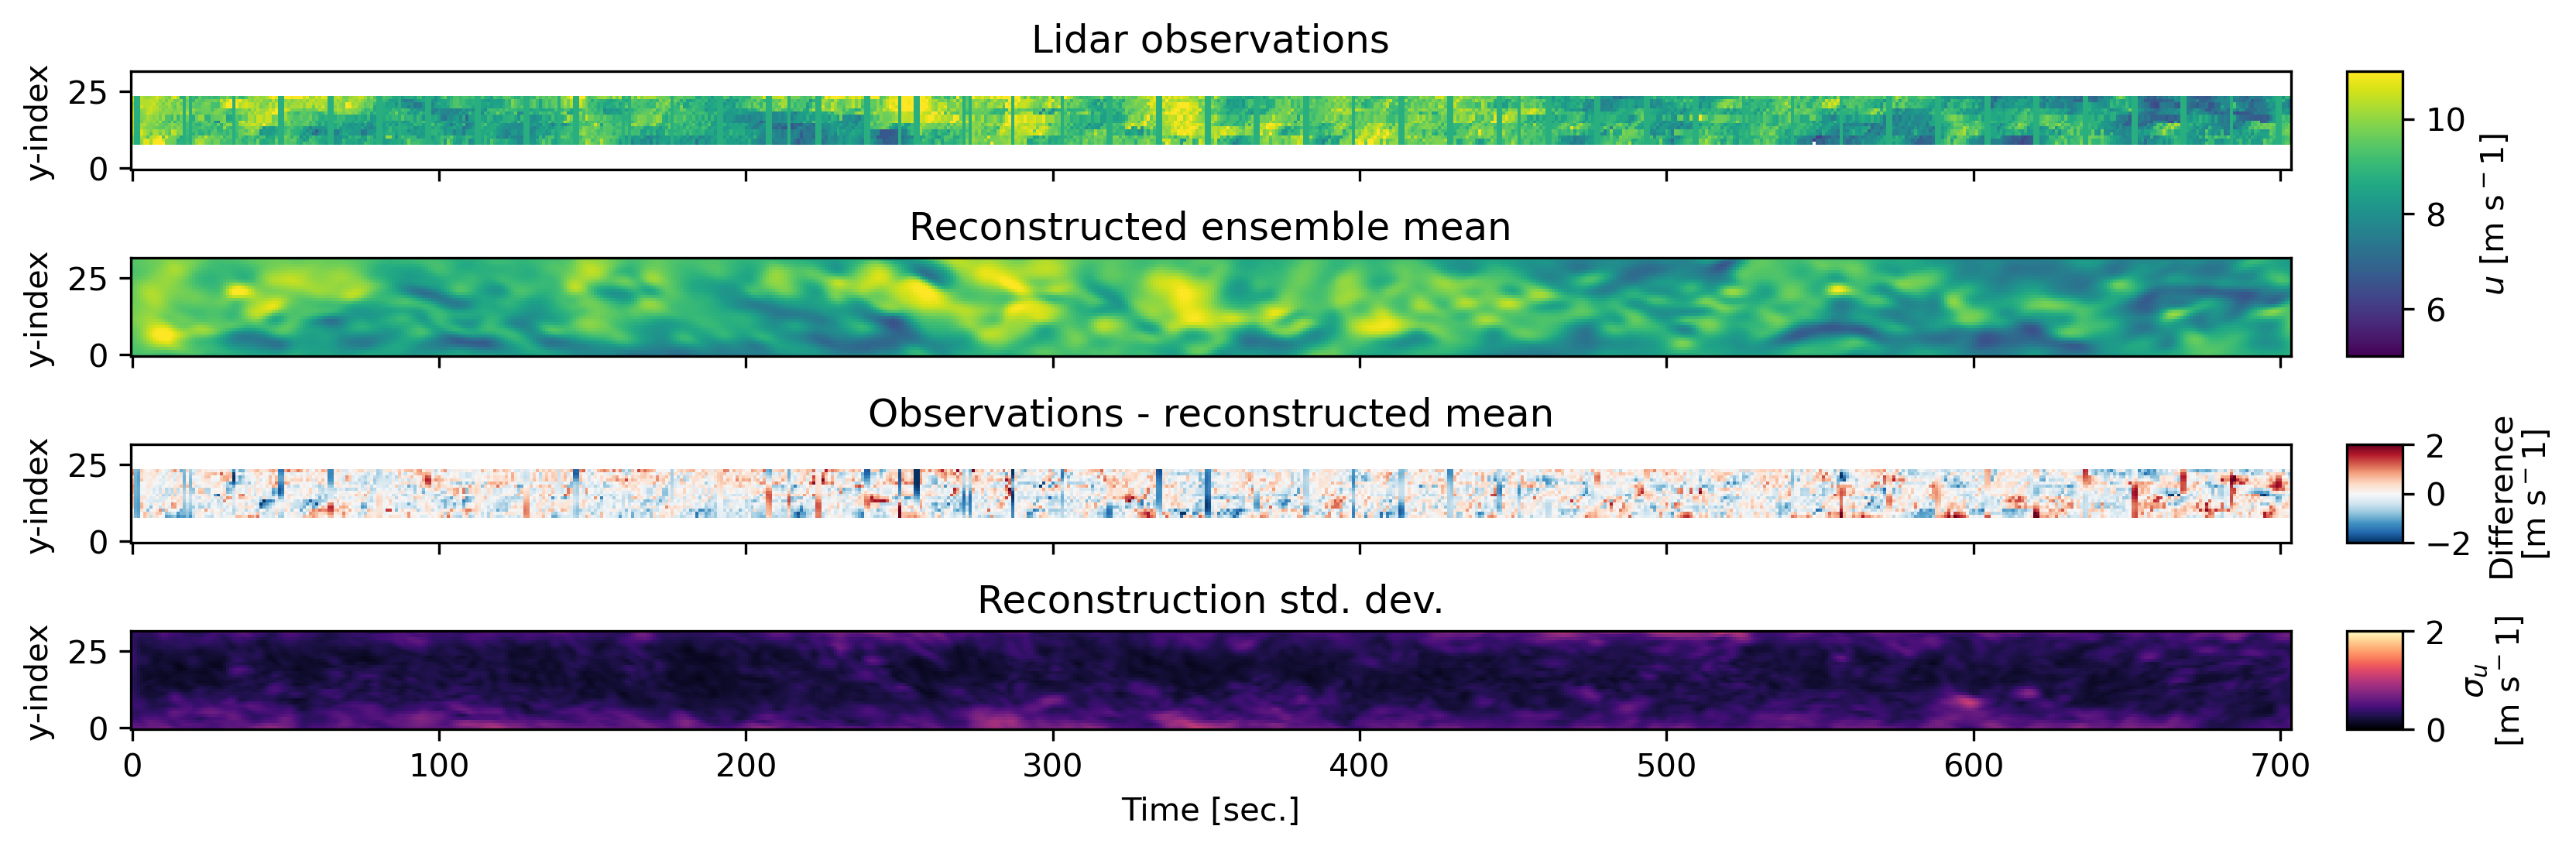

In [5]:
### Visualize data: top-down view
fig, ax = plt.subplots(4, 1, figsize=(12, 4), sharex=True, sharey=True, dpi=300)

# Decorate
vmin, vmax = 5, 11
ax[0].set_title("Lidar observations")
ax[1].set_title("Reconstructed ensemble mean")
ax[2].set_title("Observations - reconstructed mean")
ax[3].set_title("Reconstruction std. dev.")
for axs in ax:
    axs.set_ylabel('y-index')
ax[-1].set_xlabel('Time [sec.]')

# Plot
data0 = ds_in['lidar_meas'].isel(height=11).T
data1 = ds_in['u_output'].isel(height=11).mean('ens').T
data2 = data0 - data1
data3 = ds_in['u_output'].isel(height=11).std('ens').T

im0 = ax[0].imshow(data0,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im1 = ax[1].imshow(data1,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im2 = ax[2].imshow(data2,
             origin='lower',
             vmin=-2,
             vmax=2,
             cmap='RdBu_r')
im3 = ax[3].imshow(data3,
             origin='lower',
             vmin=0,
             vmax=2,
             cmap='magma')

cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

cax1 = fig.add_axes([ax[2].get_position().x1+0.02,
                     ax[2].get_position().y0,
                     0.02,
                     ax[2].get_position().y1-ax[2].get_position().y0])
cbar1 = fig.colorbar(im2, cax=cax1)
cbar1.set_label(f'Difference\n[m s$^{-1}$]')
cbar1.ax.tick_params()

cax2 = fig.add_axes([ax[3].get_position().x1+0.02,
                     ax[3].get_position().y0,
                     0.02,
                     ax[3].get_position().y1-ax[3].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label(f'$\sigma_u$\n[m s$^{-1}$]')
cbar2.ax.tick_params()

plt.show()

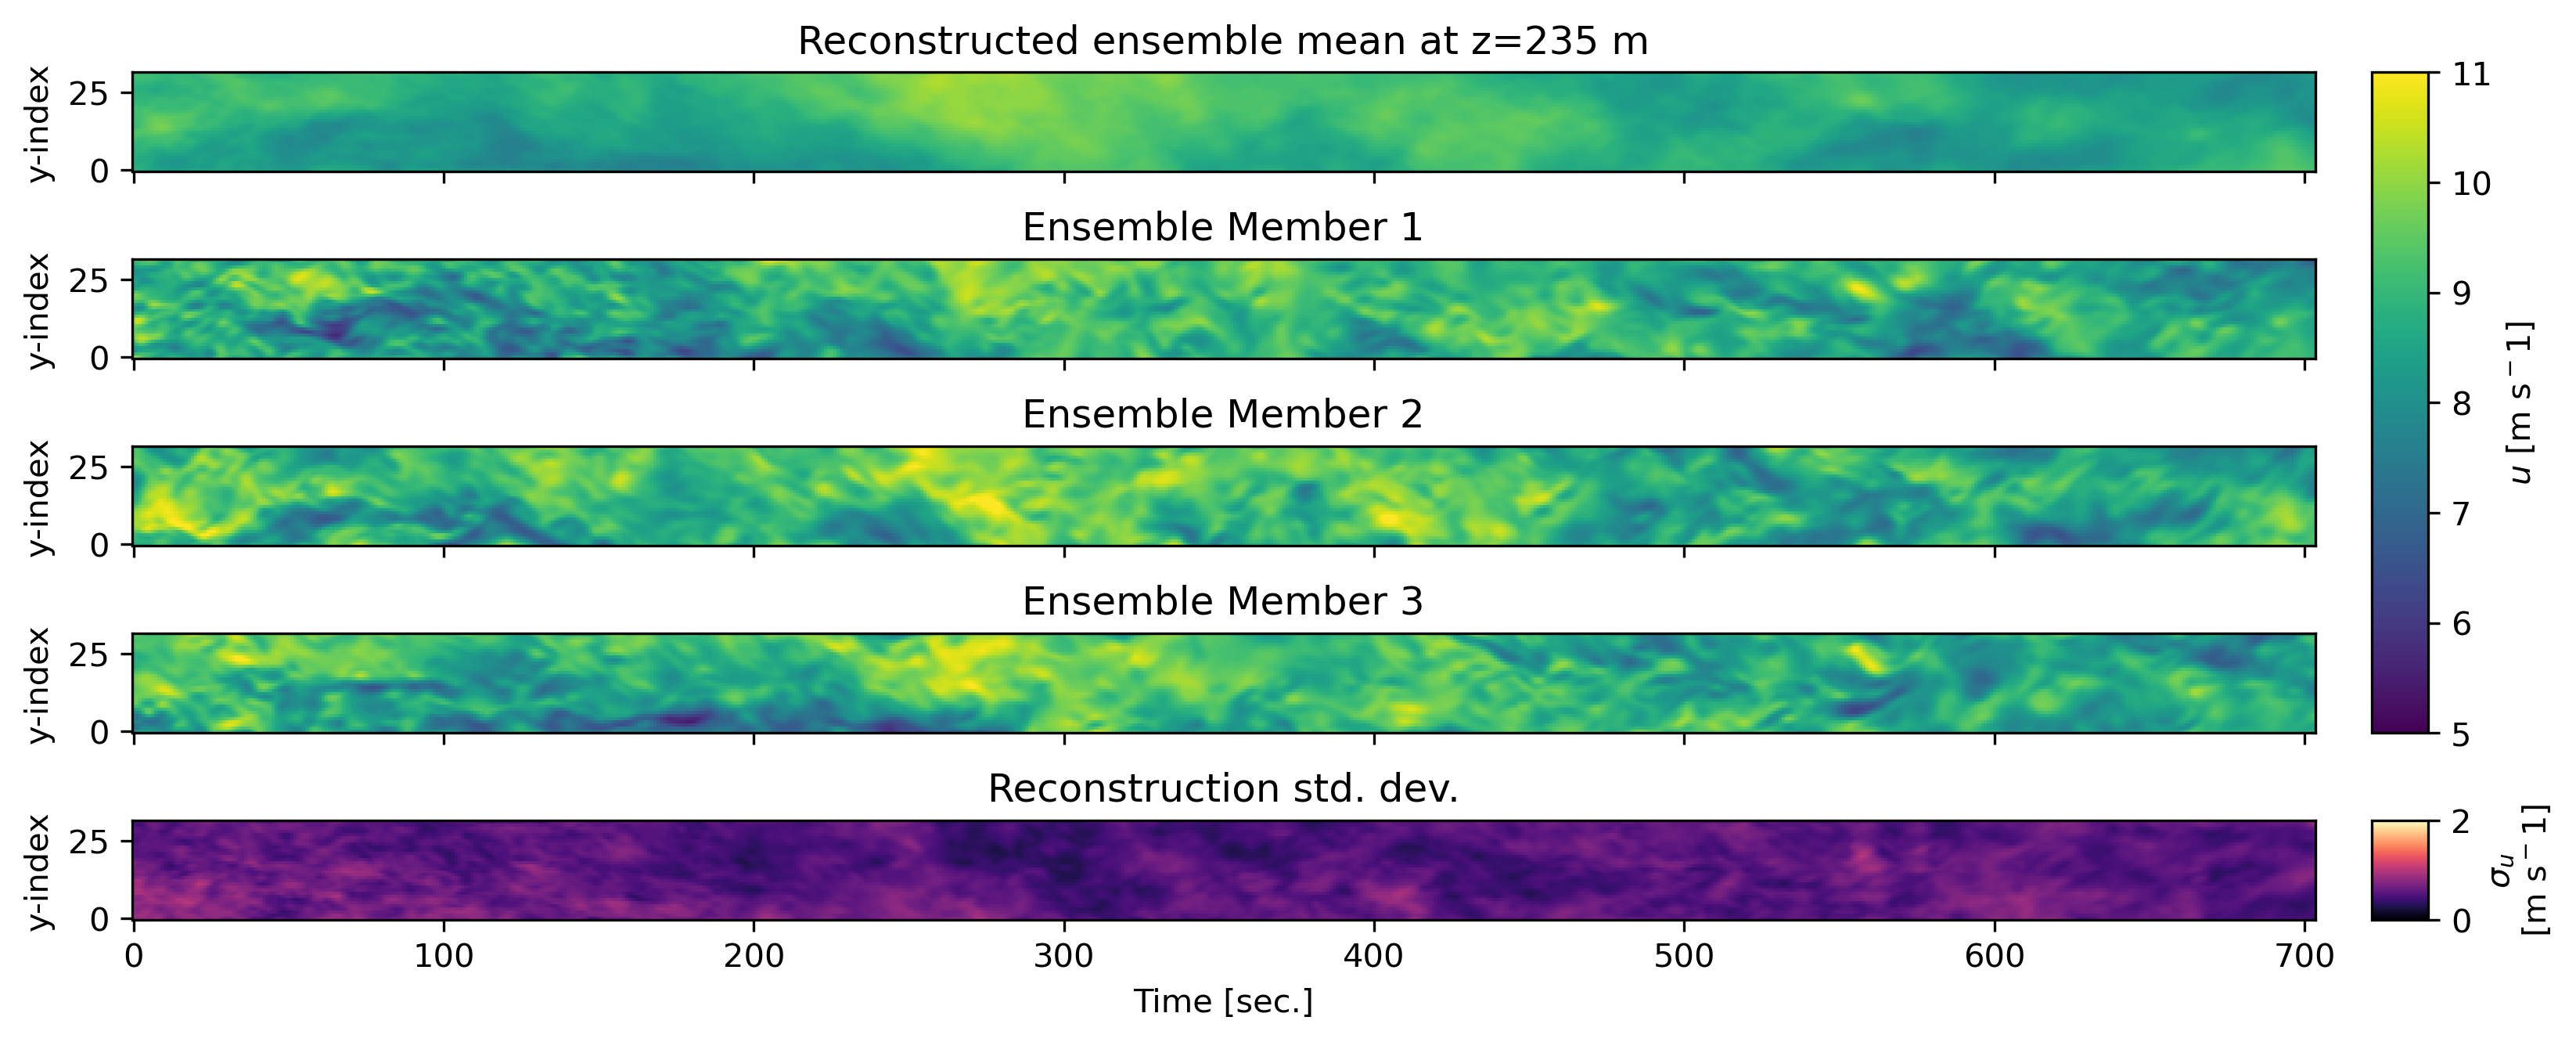

In [6]:
### Visualize data: top-down view
fig, ax = plt.subplots(5, 1, figsize=(12, 5), sharex=True, sharey=True, dpi=300)

# Decorate
kplt = 23
ax[0].set_title(f"Reconstructed ensemble mean at z={5+ds_in['height'].values[kplt]:.0f} m")
ax[1].set_title("Ensemble Member 1")
ax[2].set_title("Ensemble Member 2")
ax[3].set_title("Ensemble Member 3")
ax[4].set_title("Reconstruction std. dev.")
for axs in ax:
    axs.set_ylabel('y-index')
ax[-1].set_xlabel('Time [sec.]')

# Plot
data0 = ds_in['u_output'].isel(height=kplt).mean('ens').T
data1 = ds_in['u_output'].isel(height=kplt, ens=0).T
data2 = ds_in['u_output'].isel(height=kplt, ens=1).T
data3 = ds_in['u_output'].isel(height=kplt, ens=2).T
data4 = ds_in['u_output'].isel(height=kplt).std('ens').T
vmin, vmax = int(data0.mean()-3), int(data0.mean()+3)


im0 = ax[0].imshow(data0,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im1 = ax[1].imshow(data1,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im2 = ax[2].imshow(data2,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im3 = ax[3].imshow(data3,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im4 = ax[4].imshow(data4,
             origin='lower',
             vmin=0,
             vmax=2,
             cmap='magma')

cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[3].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[3].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

cax4 = fig.add_axes([ax[-1].get_position().x1+0.02,
                     ax[-1].get_position().y0,
                     0.02,
                     ax[-1].get_position().y1-ax[-1].get_position().y0])
cbar4 = fig.colorbar(im4, cax=cax4)
cbar4.set_label(f'$\sigma_u$\n[m s$^{-1}$]')
cbar4.ax.tick_params()

plt.show()

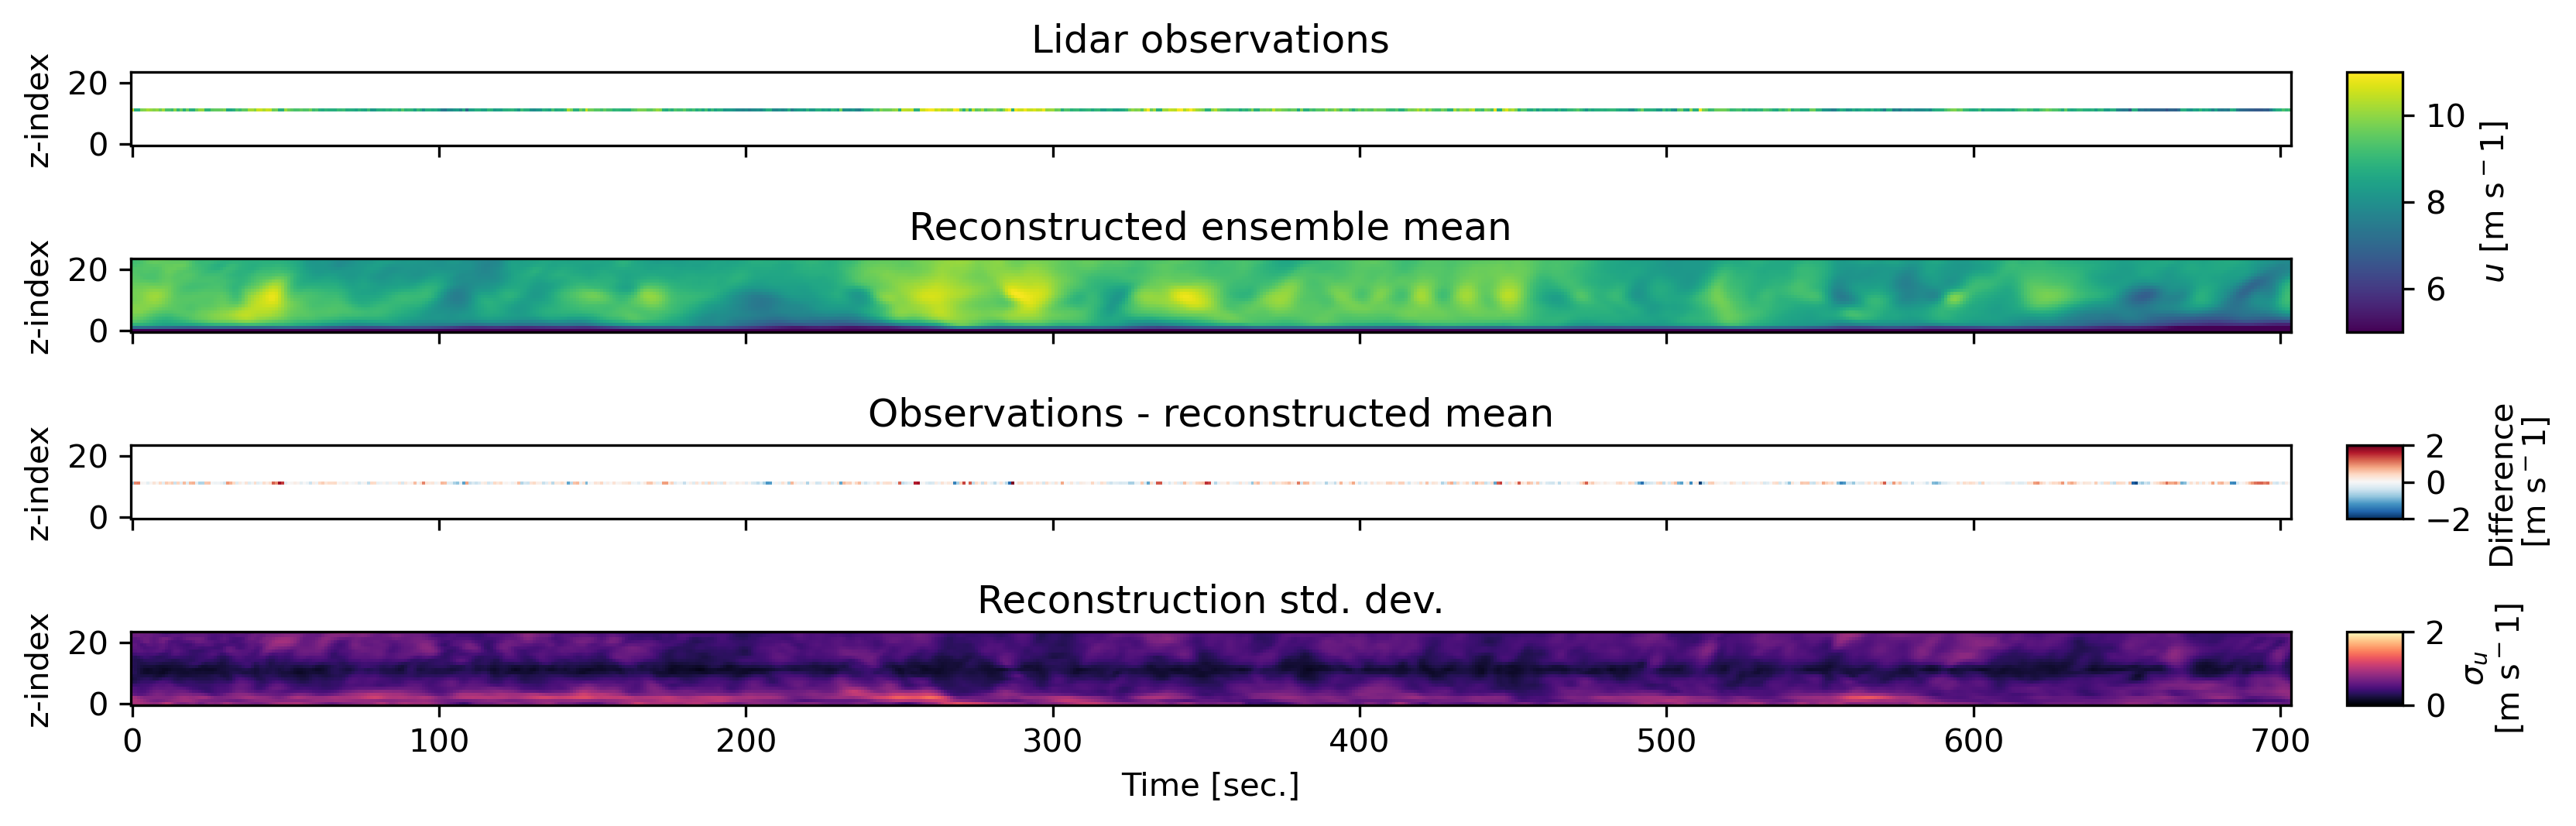

In [7]:
### Visualize data: side view
fig, ax = plt.subplots(4, 1, figsize=(12, 4), sharex=True, dpi=300)

# Decorate
vmin, vmax = 5, 11
ax[0].set_title("Lidar observations")
ax[1].set_title("Reconstructed ensemble mean")
ax[2].set_title("Observations - reconstructed mean")
ax[3].set_title("Reconstruction std. dev.")

for axs in ax:
    axs.set_ylabel('z-index')
ax[-1].set_xlabel('Time [sec.]')

# Plot
data0 = ds_in['lidar_meas'].isel(width=16).T
data1 = ds_in['u_output'].isel(width=16).mean('ens').T
data2 = data1 - data0
data3 = ds_in['u_output'].isel(width=16).std('ens').T

im0 = ax[0].imshow(data0,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im1 = ax[1].imshow(data1,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im2 = ax[2].imshow(data2,
             origin='lower',
             vmin=-2,
             vmax=2,
             cmap='RdBu_r')
im3 = ax[3].imshow(data3,
             origin='lower',
             vmin=0,
             vmax=2,
             cmap='magma')

cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

cax1 = fig.add_axes([ax[2].get_position().x1+0.02,
                     ax[2].get_position().y0,
                     0.02,
                     ax[2].get_position().y1-ax[2].get_position().y0])
cbar1 = fig.colorbar(im2, cax=cax1)
cbar1.set_label(f'Difference\n[m s$^{-1}$]')
cbar1.ax.tick_params()

cax2 = fig.add_axes([ax[3].get_position().x1+0.02,
                     ax[3].get_position().y0,
                     0.02,
                     ax[3].get_position().y1-ax[3].get_position().y0])
cbar2 = fig.colorbar(im3, cax=cax2)
cbar2.set_label(f'$\sigma_u$\n[m s$^{-1}$]')
cbar2.ax.tick_params()

plt.show()

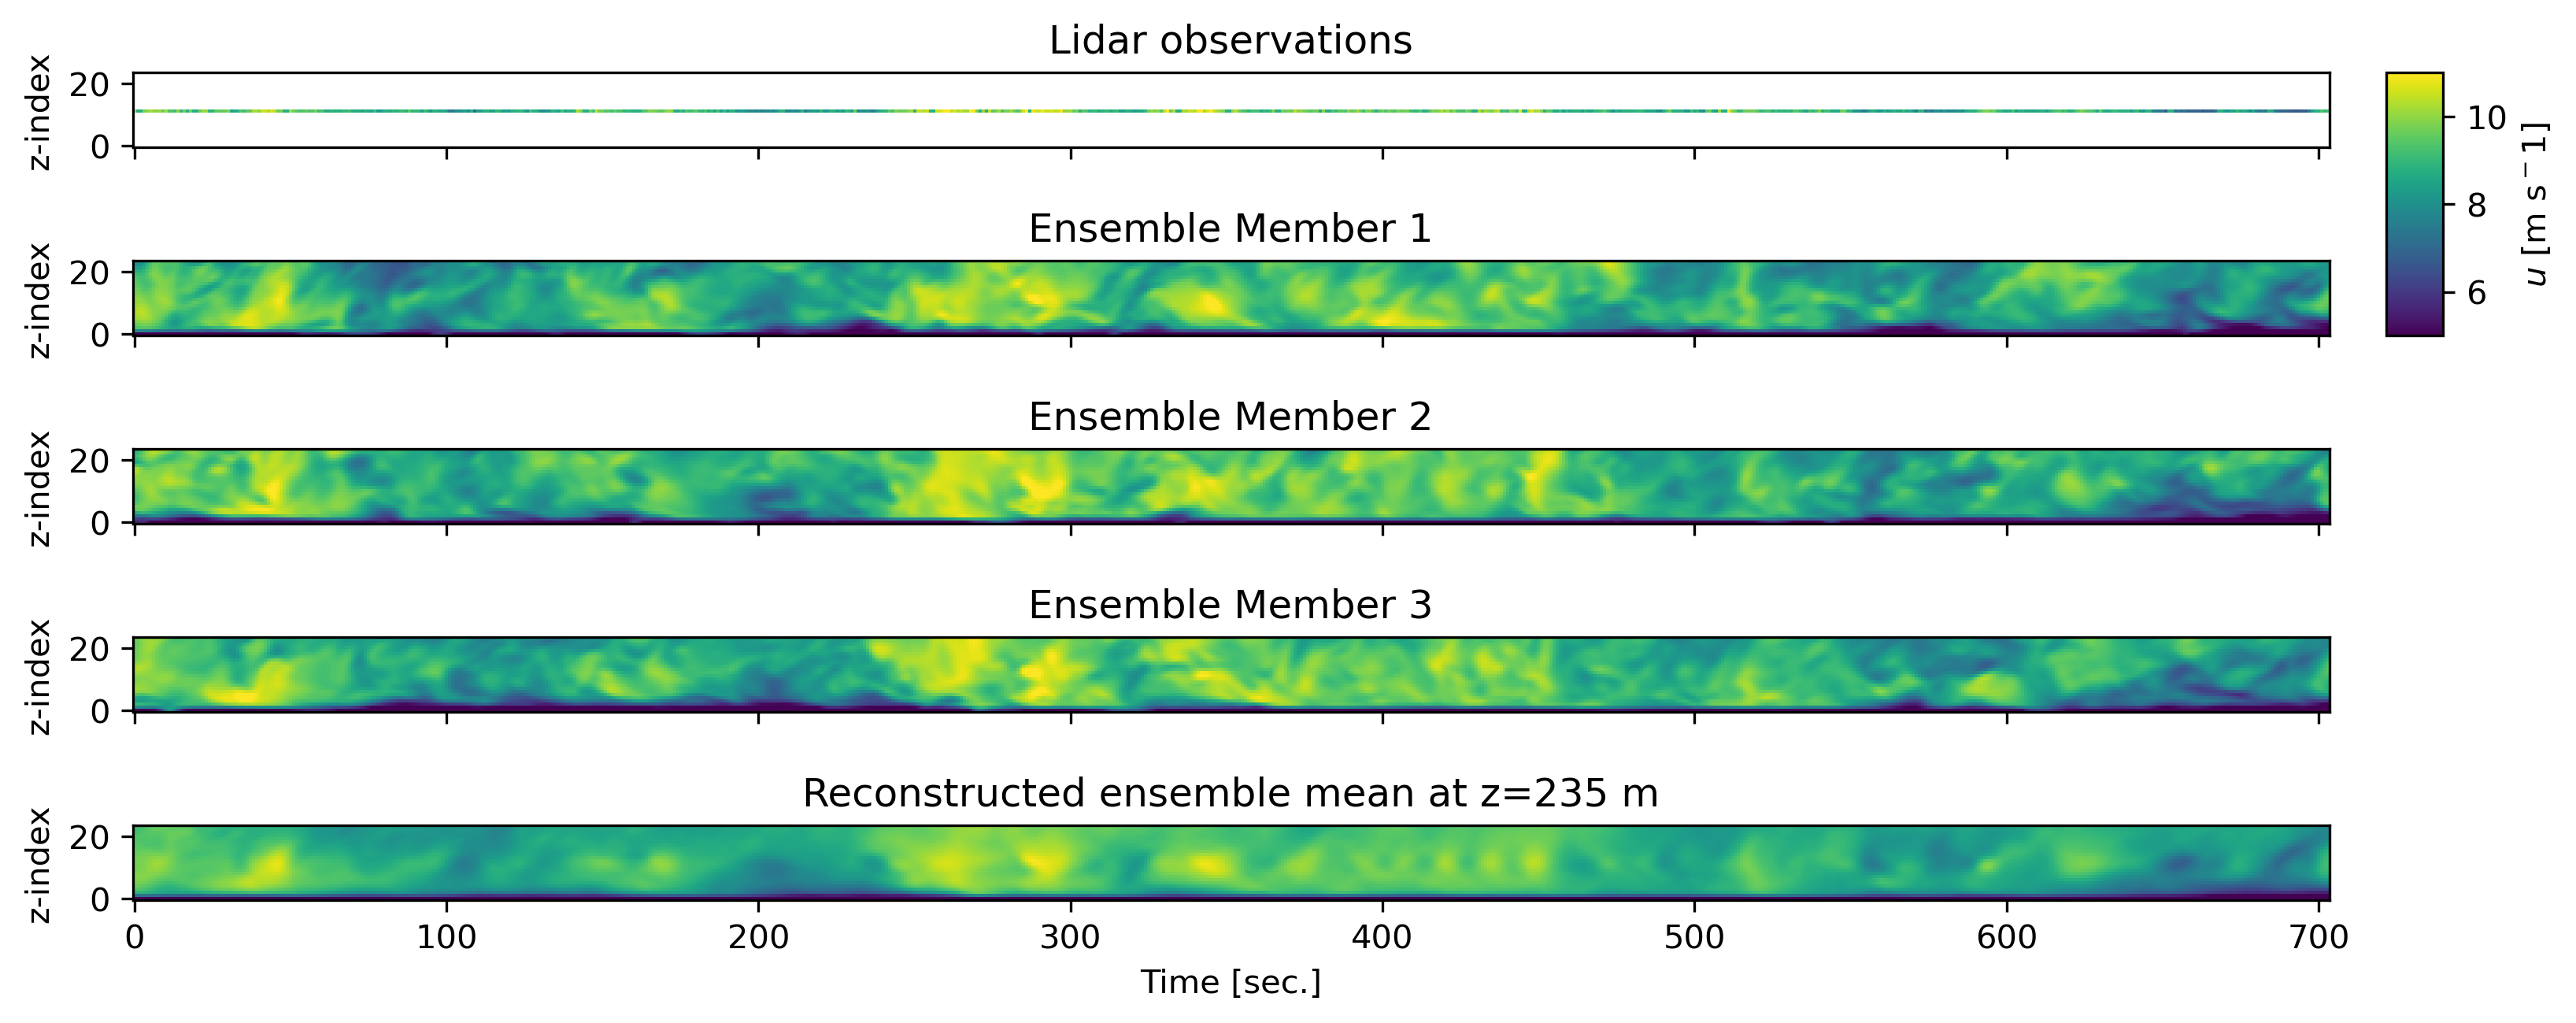

In [8]:
### Visualize data: side view
fig, ax = plt.subplots(5, 1, figsize=(12, 5), sharex=True, dpi=300)

# Decorate
vmin, vmax = 5, 11
ax[0].set_title("Lidar observations")
ax[1].set_title("Ensemble Member 1")
ax[2].set_title("Ensemble Member 2")
ax[3].set_title("Ensemble Member 3")
ax[4].set_title(f"Reconstructed ensemble mean at z={5+ds_in['height'].values[kplt]:.0f} m")

for axs in ax:
    axs.set_ylabel('z-index')
ax[-1].set_xlabel('Time [sec.]')

# Plot
data0 = ds_in['lidar_meas'].isel(width=16).T
data1 = ds_in['u_output'].isel(width=16,ens=0).T
data2 = ds_in['u_output'].isel(width=16,ens=1).T
data3 = ds_in['u_output'].isel(width=16,ens=2).T
data4 = ds_in['u_output'].isel(width=16).mean('ens').T

im0 = ax[0].imshow(data0,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im1 = ax[1].imshow(data1,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im2 = ax[2].imshow(data2,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im3 = ax[3].imshow(data3,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im4 = ax[4].imshow(data4,
             origin='lower',
             vmin=vmin,
             vmax=vmax)

cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

# cax1 = fig.add_axes([ax[2].get_position().x1+0.02,
#                      ax[2].get_position().y0,
#                      0.02,
#                      ax[2].get_position().y1-ax[2].get_position().y0])
# cbar1 = fig.colorbar(im2, cax=cax1)
# cbar1.set_label(f'Difference\n[m s$^{-1}$]')
# cbar1.ax.tick_params()

# cax2 = fig.add_axes([ax[3].get_position().x1+0.02,
#                      ax[3].get_position().y0,
#                      0.02,
#                      ax[3].get_position().y1-ax[3].get_position().y0])
# cbar2 = fig.colorbar(im3, cax=cax2)
# cbar2.set_label(f'$\sigma_u$\n[m s$^{-1}$]')
# cbar2.ax.tick_params()

plt.show()

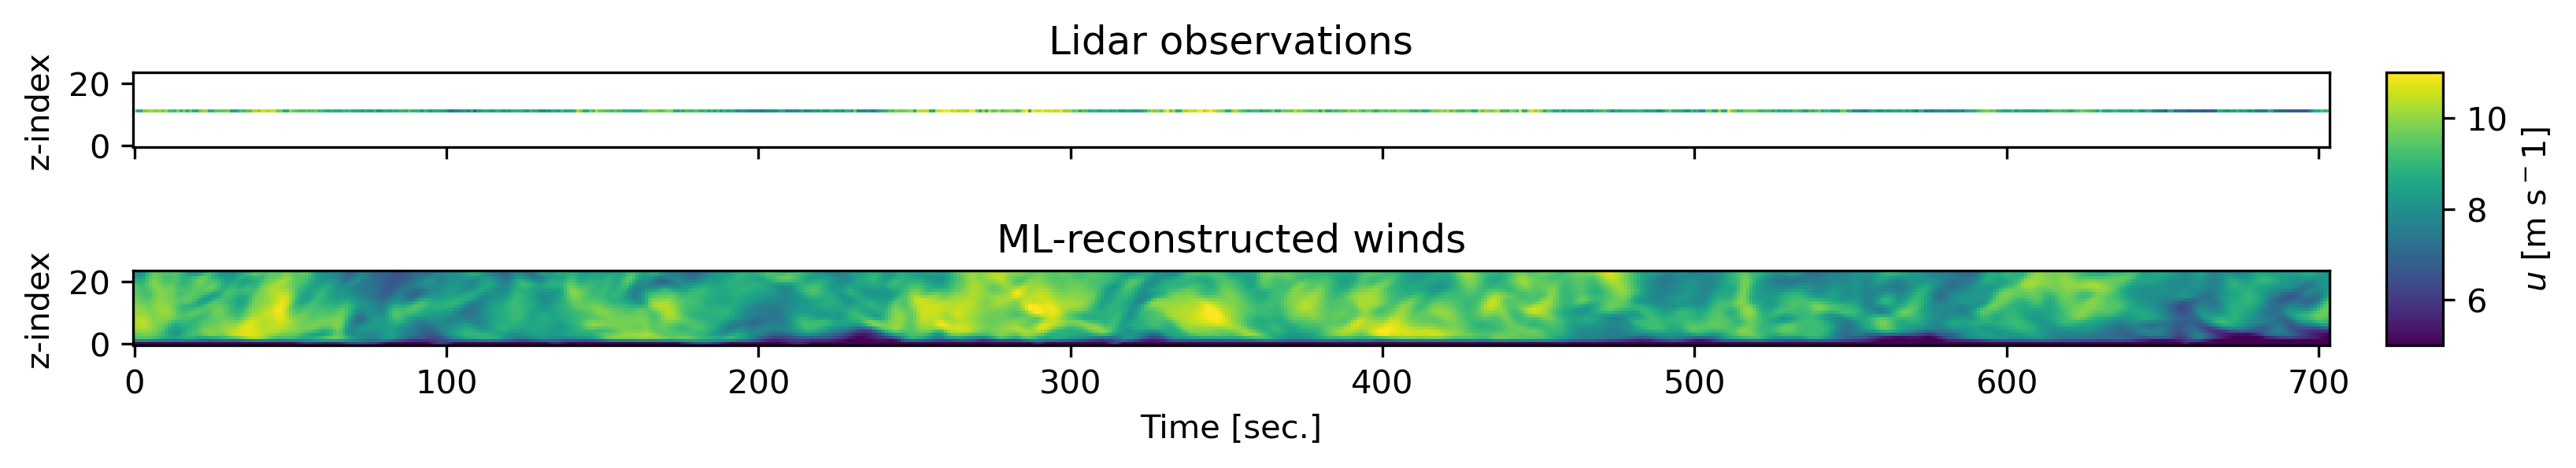

In [9]:
ds_in### Visualize data: side view
fig, ax = plt.subplots(2, 1, figsize=(12, 2), sharex=True, dpi=300)

# Decorate
vmin, vmax = 5, 11
ax[0].set_title("Lidar observations")
ax[1].set_title("ML-reconstructed winds")
# ax[2].set_title("Ensemble Member 2")
# ax[3].set_title("Ensemble Member 3")
# ax[4].set_title(f"Reconstructed ensemble mean at z={5+ds_in['height'].values[kplt]:.0f} m")

for axs in ax:
    axs.set_ylabel('z-index')
ax[-1].set_xlabel('Time [sec.]')

# Plot
data0 = ds_in['lidar_meas'].isel(width=16).T
data1 = ds_in['u_output'].isel(width=16,ens=0).T
data2 = ds_in['u_output'].isel(width=16,ens=1).T
data3 = ds_in['u_output'].isel(width=16,ens=2).T
data4 = ds_in['u_output'].isel(width=16).mean('ens').T

im0 = ax[0].imshow(data0,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im1 = ax[1].imshow(data1,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
# im2 = ax[2].imshow(data2,
#              origin='lower',
#              vmin=vmin,
#              vmax=vmax)
# im3 = ax[3].imshow(data3,
#              origin='lower',
#              vmin=vmin,
#              vmax=vmax)
# im4 = ax[4].imshow(data4,
#              origin='lower',
#              vmin=vmin,
#              vmax=vmax)

cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

# cax1 = fig.add_axes([ax[2].get_position().x1+0.02,
#                      ax[2].get_position().y0,
#                      0.02,
#                      ax[2].get_position().y1-ax[2].get_position().y0])
# cbar1 = fig.colorbar(im2, cax=cax1)
# cbar1.set_label(f'Difference\n[m s$^{-1}$]')
# cbar1.ax.tick_params()

# cax2 = fig.add_axes([ax[3].get_position().x1+0.02,
#                      ax[3].get_position().y0,
#                      0.02,
#                      ax[3].get_position().y1-ax[3].get_position().y0])
# cbar2 = fig.colorbar(im3, cax=cax2)
# cbar2.set_label(f'$\sigma_u$\n[m s$^{-1}$]')
# cbar2.ax.tick_params()

plt.show()

0 8.850355053429181
1 -0.3114467147145082
2 0.4900283743391011
3 318.7910674023357
4 0.08506393704742413


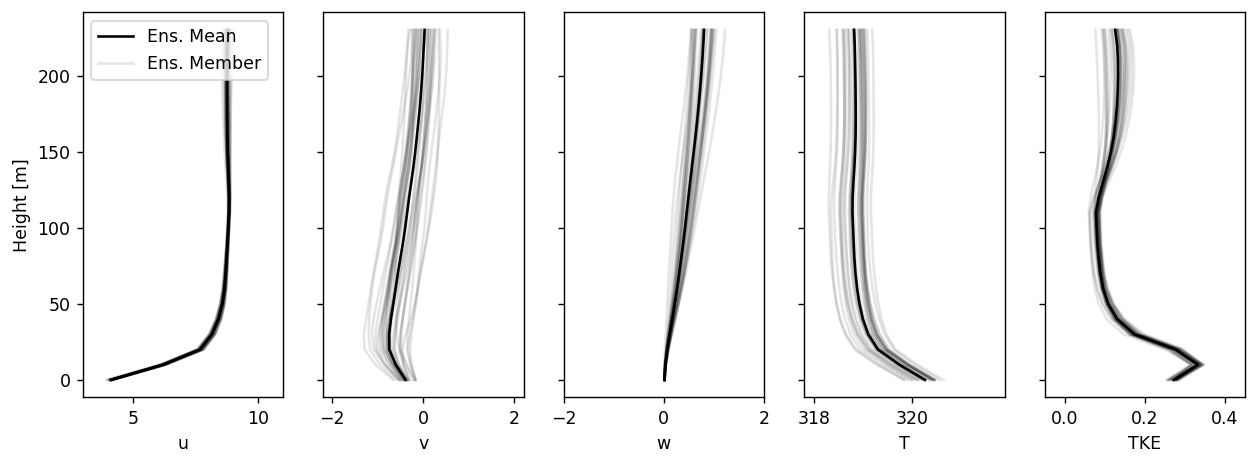

In [10]:
### Look at 1D profiles of reconstructions
fig, ax = plt.subplots(1, 5, figsize=(12, 4), sharey=True, dpi=125)

varlist = ['u', 'v', 'w', 'T', 'TKE']
for ivar, currvar in enumerate(varlist):
    ### u-component
    ax[ivar].plot(ds_in[f'{currvar}_output'].mean(('ens', 'time', 'width')).values,
                 ds_in['height'].values,
                 color='k',
                 label='Ens. Mean')
    print(ivar, ds_in[f'{currvar}_output'].sel(height=120).mean(('ens', 'time', 'width')).values)
    for iens in range(len(ds_in['ens'])):
        if iens==0:
            currlabel='Ens. Member'
        else:
            currlabel=None
        ax[ivar].plot(ds_in[f'{currvar}_output'].isel(ens=iens).mean(('time', 'width')).values,
                     ds_in['height'].values,
                     color='k',
                     alpha=0.1,
                     label=currlabel)
    
    ax[ivar].set_xlabel(currvar)
ax[0].set_ylabel("Height [m]")
ax[0].legend(loc='upper left')
ax[0].set_xlim(3, 11)
ax[1].set_xlim(-2.2, 2.2)
ax[2].set_xlim(-2, 2)
ax[3].set_xlim(317.8, 321.9)
ax[4].set_xlim(-0.05, 0.45)
    
plt.show()

### Verify that the BC network is copy-pasting the denoised lidar conditioning

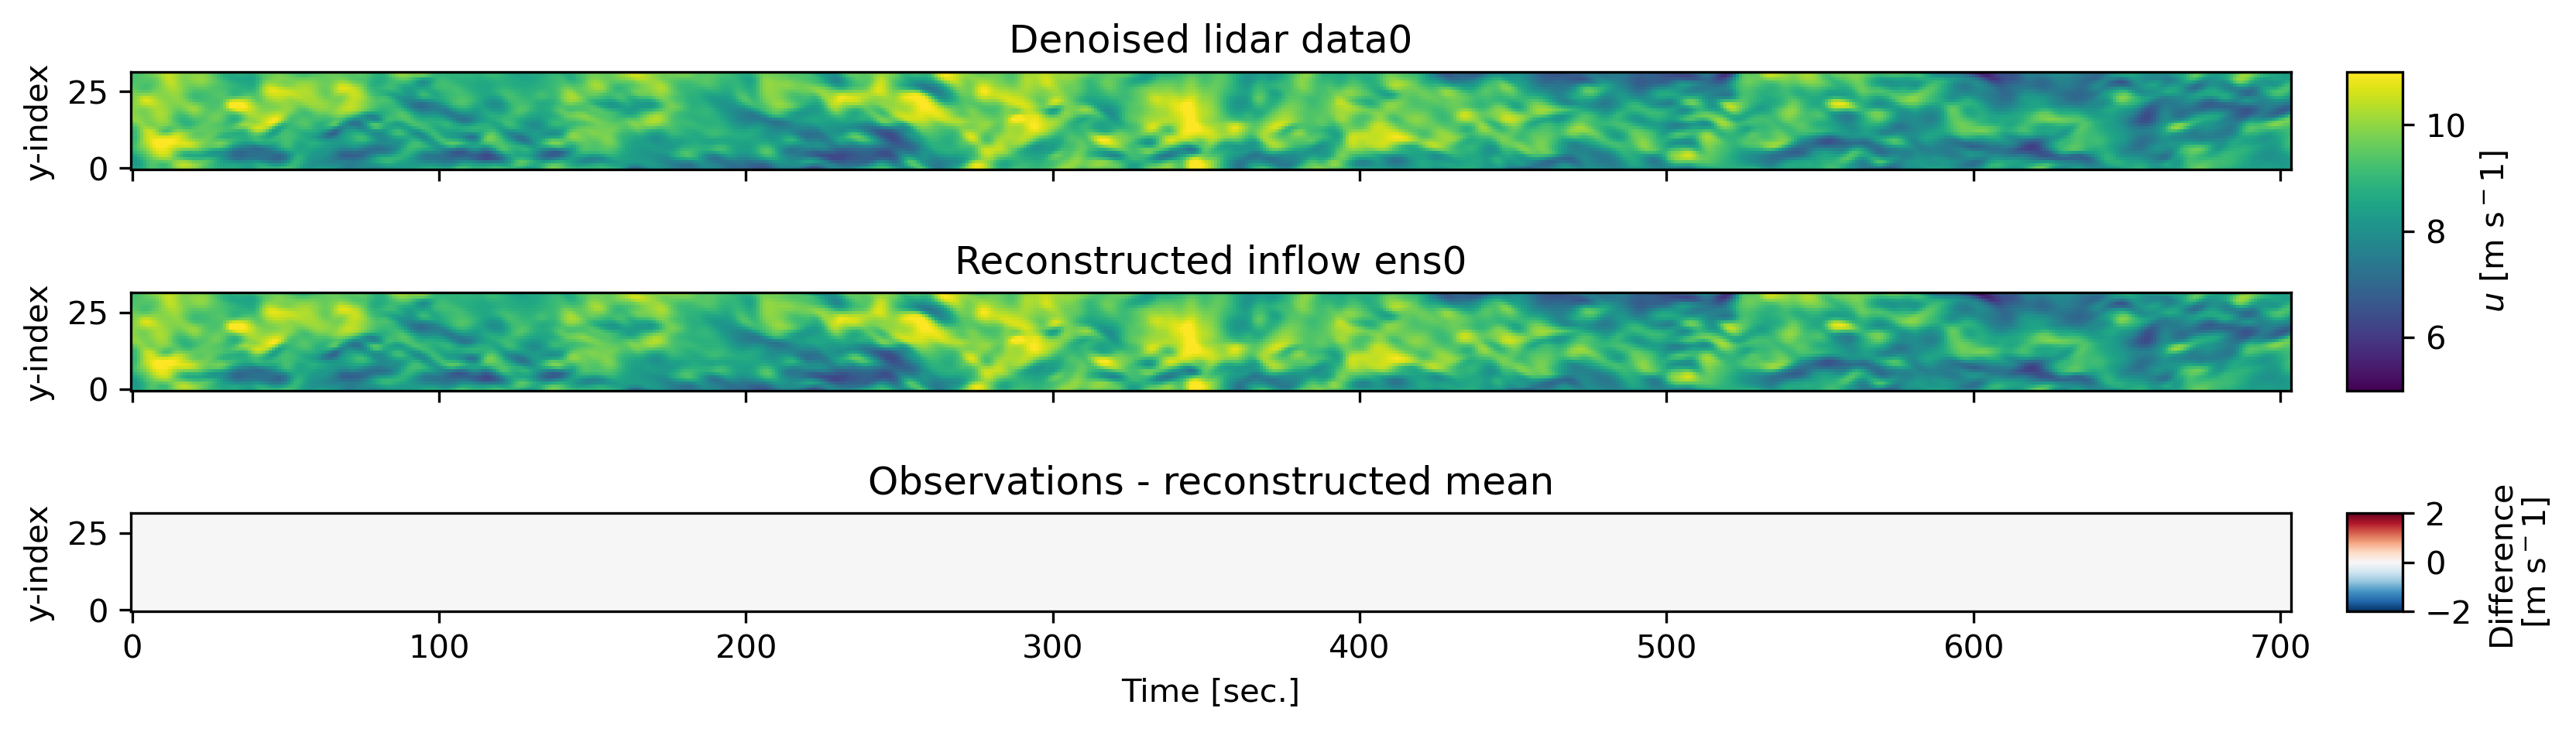

In [11]:
### Visualize data: top-down view
fig, ax = plt.subplots(3, 1, figsize=(12, 3.5), sharex=True, sharey=True, dpi=300)

# Decorate
vmin, vmax = 5, 11
ax[0].set_title("Denoised lidar data0")
ax[1].set_title("Reconstructed inflow ens0")
ax[2].set_title("Observations - reconstructed mean")
for axs in ax:
    axs.set_ylabel('y-index')
ax[-1].set_xlabel('Time [sec.]')

# Plot
data0 = ds_in['u_input'].isel(height=11,ens=0).T
data1 = ds_in['u_output'].isel(height=11,ens=0).T
data2 = data0 - data1

im0 = ax[0].imshow(data0,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im1 = ax[1].imshow(data1,
             origin='lower',
             vmin=vmin,
             vmax=vmax)
im2 = ax[2].imshow(data2,
             origin='lower',
             vmin=-2,
             vmax=2,
             cmap='RdBu_r')

cax0 = fig.add_axes([ax[0].get_position().x1+0.02,
                     ax[1].get_position().y0,
                     0.02,
                     ax[0].get_position().y1-ax[1].get_position().y0])
cbar0 = fig.colorbar(im0, cax=cax0)
cbar0.set_label(f'$u$ [m s$^{-1}$]')
cbar0.ax.tick_params()

cax1 = fig.add_axes([ax[2].get_position().x1+0.02,
                     ax[2].get_position().y0,
                     0.02,
                     ax[2].get_position().y1-ax[2].get_position().y0])
cbar1 = fig.colorbar(im2, cax=cax1)
cbar1.set_label(f'Difference\n[m s$^{-1}$]')
cbar1.ax.tick_params()

# cax2 = fig.add_axes([ax[3].get_position().x1+0.02,
#                      ax[3].get_position().y0,
#                      0.02,
#                      ax[3].get_position().y1-ax[3].get_position().y0])
# cbar2 = fig.colorbar(im3, cax=cax2)
# cbar2.set_label(f'$\sigma_u$\n[m s$^{-1}$]')
# cbar2.ax.tick_params()

plt.show()

In [12]:
ds_in

<xarray.Dataset>
Dimensions:     (ens: 30, time: 704, width: 32, height: 24)
Coordinates:
  * ens         (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 21 22 23 24 25 26 27 28 29
  * time        (time) datetime64[ns] 2023-07-24T16:00:25 ... 2023-07-24T16:1...
  * width       (width) int64 0 10 20 30 40 50 60 ... 260 270 280 290 300 310
  * height      (height) int64 0 10 20 30 40 50 60 ... 180 190 200 210 220 230
Data variables: (12/16)
    u_input     (ens, time, width, height) float64 ...
    u_mask      (ens, time, width, height) float64 ...
    u_output    (ens, time, width, height) float64 4.466 5.57 ... 8.576 8.87
    v_input     (ens, time, width, height) float64 ...
    v_mask      (ens, time, width, height) float64 ...
    v_output    (ens, time, width, height) float64 -1.86 0.1492 ... 0.9775 1.04
    ...          ...
    T_mask      (ens, time, width, height) float64 ...
    T_output    (ens, time, width, height) float64 320.2 319.9 ... 319.0 319.0
    TKE_input   (ens, time, width, height) float64 ...
    TKE_mask    (ens, time, width, height) float64 ...
    TKE_output  (ens, time, width, height) float64 0.1557 0.7187 ... 0.05146
    lidar_meas  (time, width, height) float64 nan nan nan nan ... nan nan nan